# Construyendo una red neuronal con PyTorch

## Ayudas

Al final de esta notebook hay un [listado de referencias](#Listado-de-referencias) con hipervínculos.

## Librerías

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

## Cargando los datos del CIFAR10

- El conjunto de datos a utilizar es el **[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**.
- Es un conjunto estándar para hacer *reconocimiento de imágenes*.
- Buscamos entrenar un clasificador que reconozca que está siendo mostrado en la imagen de un conjunto fijo de categorías posibles.
- El CIFAR-10 está compuesto por imágenes a color de 32x32 píxeles representadas como tensores de 32x32x3, donde la tercera dimensión representa el *channel* (i.e. el color en RGB). Los valores representan la intensidad de cada color en dicho pixel.
- La salida son 10 clases: avión, auto, pájaro, gato, siervo, perro, sapo, caballo, bote, camión.
- La librería `torchvision` nos facilita obtener el conjunto de datos.

In [2]:
CIFAR_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 128  # For mini-batch gradient descent
EPOCHS = 2

# This is to normalize from PILImage to Torch Tensors in range [-1, 1]
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Creación del objeto trainset para ser utilizado como parámetro de entrada para la creación del objeto trainloader
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=False,
                                        transform=transform)
# Creación del objeto trainloader. Este devuelve un iterable sobre el dataset trainset
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=False,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=2)

In [3]:
print('Propiedades de los objetos trainset y testset:')
keys = trainset.__dict__.keys()
for key in keys:
    print('-', key)
print('Propiedades de los objetos trainloader y testloader:')
keys = trainloader.__dict__.keys()
for key in keys:
    print('-', key)

Propiedades de los objetos trainset y testset:
- root
- transform
- target_transform
- transforms
- train
- data
- targets
- classes
- class_to_idx
Propiedades de los objetos trainloader y testloader:
- dataset
- num_workers
- prefetch_factor
- pin_memory
- pin_memory_device
- timeout
- worker_init_fn
- _DataLoader__multiprocessing_context
- _dataset_kind
- batch_size
- drop_last
- sampler
- batch_sampler
- generator
- collate_fn
- persistent_workers
- _DataLoader__initialized
- _IterableDataset_len_called
- _iterator


## Explorando el CIFAR-10

Vamos a explorar algunas de las imágenes que muestra el conjunto de datos del CIFAR-10.

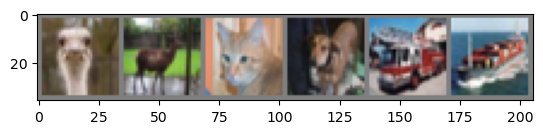

 bird	 deer	  cat	  dog	truck	 ship


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# obtener algunas imágenes de entrenamiento
image_number =  6 #Pueden probar cambiar este numero para obtener más imagenes

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:image_number]
labels = labels[:image_number]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % CIFAR_CLASSES[labels[j]] for j in range(image_number)))

## Arquitectura de la red neuronal

La primera decisión a la hora de construir un modelo neuronal es la cantidad de capas, la cantidad y tipo de neuronas en cada capa, y las conexiones entre capas.

Comenzaremos por construir el modelo más básico posible: un [**perceptrón multicapa**](https://en.wikipedia.org/wiki/Multilayer_perceptron) o MLP. Se compone de N capas lineares, seguidas de una activación no lineal. En la capa lineal, cada neurona se conecta con todas las neuronas de la capa anterior (por eso se llaman *fully connected*).

La forma más rápida de implementar el modelo es utilizando los siguientes objetos de Torch:

- La capa *lineal* fully connected se construye con [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).
    - Internamente tiene dos tensores: una matriz de pesos y un vector de biases. PyTorch nos abstrae de eso.
    - Es equivalente a la capa [`Dense`](https://keras.io/api/layers/core_layers/dense/) de [Keras](https://keras.io/).
- La función de activación *relu* se construye con [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), que aplica una transformación relu a todas las neuronas de la capa anterior.
- Las capas se conectan entre sí con el modelo [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). Es un modelo donde cada capa recibe como entrada la salida de la capa anterior.
    - Es limitado en sus usos posibles, pero tiene la ventaja de abstraer completamente del funcionamiento.
    - Es equivalente al modelo [`tf.keras.Sequential`](https://keras.io/api/models/sequential/#sequential-class) de Keras.

```python
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)
```

### Modelo de PyTorch

En esta materia vamos a utilizar el paradigma funcional de PyTorch para construir nuestras redes, ya que permite un grado de personalización mucho más profundo. 

Los modelos en PyTorch heredan de la clase [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). La clase posee dos métodos que requieren definirse:
1. `__init__`: Define la estructura de la red (i.e las capas que tiene).
2. `forward`: Define como interactúan las capas de la red (i.e. las operaciones que se realizan sobre los tensores).

In [5]:
# import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = torch.nn.Linear(32 * 32 * 3, 512)
        self.hidden_layer2 = torch.nn.Linear(512, 256)
        self.output_layer = torch.nn.Linear(256, 10)
    
    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x)  # Go through hidden layer 1
        x = torch.nn.functional.relu(x)  # Activation Function layer 1
        x = self.hidden_layer2(x) # Go through hidden layer 2
        x = torch.nn.functional.relu(x)  # Activation Function layer 2
        x = self.output_layer(x)  # Output Layer
        return x

model = MLP()

Podemos inspeccionar el modelo simplemente imprimiéndolo

In [6]:
print(model)

MLP(
  (hidden_layer1): Linear(in_features=3072, out_features=512, bias=True)
  (hidden_layer2): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)


Podemos ver que nos devuelve el modelo inicializado al azar (notar que este modelo no requiere reordenar la matriz que representa la imagen):

In [7]:
img_check, lbl_check = dataiter.next()
img_check, lbl_check = img_check[0], lbl_check[0]

print(f"Clase real: {CIFAR_CLASSES[lbl_check]}")
print(f"Clase devuelta: {CIFAR_CLASSES[model(img_check.view(-1)).argmax().item()]}")

Clase real: dog
Clase devuelta: horse


## Preparando el modelo para entrenarlo

- Para minimizar una red neuronal necesitamos *calcular sus gradientes*. Esto se hace con el algoritmo de **retropropagación**.
- PyTorch tiene la capacidad de hacerlo automáticamente. Esto se conoce como _diferenciación automática_ y es algo común en los frameworks de deep learning.
- Necesitaremos definir dos componentes para entrenar un modelo: la función de costo y el algoritmo de optimización.

### Función de costo

- La función de costo puede cambiar de acuerdo al tipo de problema (clasificación binaria/multiclase o regresión).
    - La funciones más comunes son la media del error cuadrático (_mean squared error_) para regresión y la entropía cruzada (_crossentropy_) para clasificación.
    - Las funciones de costo necesitan ser diferenciables, las más comunes ya están implementadas (con sus respectivas derivadas) en PyTorch.

### Algoritmo de optimización

- El algoritmo de optimización es el que entrena la red. Existen varios, que en si son variaciones del algoritmo de _descenso por la gradiente_.
    - El módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html) tiene implementados varios algoritmos de optimización muy utilizados en aprendizaje automático.

<div style="text-align: center; margin: 5px 0;">
    <div style="display: inline-block;">
        <img src="https://github.com/DiploDatos/AprendizajeProfundo/blob/master/images/contours_evaluation_optimizers.gif?raw=1" alt="Optimización" style="width:350px;"/>
    </div>
    <div style="display: inline-block;">
        <img src="https://github.com/DiploDatos/AprendizajeProfundo/blob/master/images/saddle_point_evaluation_optimizers.gif?raw=1" alt="Optimización" style="width:350px;"/>
    </div>
</div>
<div style="text-align:right;font-size:0.75em;">Fuente: <a href="http://ruder.io/optimizing-gradient-descent/" target="_blank">http://ruder.io/optimizing-gradient-descent/</a></div>

In [8]:
model = MLP()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Entrenamiento

- Ya teniendo todos los parámetros definidos, el modelo está listo para entrenarse.
- PyTorch no provee una solución "out-of-the-box" para el bucle de entrenamiento (o en inglés *training loop*), a diferencia de scikit-learn y Keras que proveen `fit` y `predict`. Existen algunas librerías que proveen dicha abstracción, pero dejamos como ejercicio [buscar alguna](https://pytorch.org/ecosystem/) si lo consideran necesario.
- En general si bien el hecho de tener que hacer el loop de entrenamiento desde cero es un poco tedioso, da lugar a mucha más personalización y control del proceso de entrenamiento.

In [ ]:
# Este código es para tratar de entender el dataset
pbar = tqdm(trainloader)
for i, data in enumerate(pbar, 1):
    inputs, labels = data
    print(type(inputs), type(labels))
    print(inputs.shape)
    print(inputs.view(inputs.shape[0], -1).shape)
    print(labels.shape)
    inputs.view(inputs.shape[0], -1)
    seguimos = input('¿Seguimos? (s/n)')
    if seguimos == 'n':
        break

In [9]:
EPOCHS = 2
model.train()  # Tell the model to set itself to "train" mode.
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(trainloader)
    for i, data in enumerate(pbar, 1):
        # get the inputs; data is a list of [inputs, labels]
        # inputs: tensor de Torch de dimensión [BATCH_SIZE, 3, 32, 32]
        # labels: tensor de Torch de dimensión [BATCH_SIZE]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.view(inputs.shape[0], -1)) # Al modelo le ingreso como argumento un
                                                          # tensor de Torch de dimensión [BATCH_SIZE, 3072]
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i > 0 and i % 50 == 0:    # print every 50 mini-batches
            pbar.set_description(f"[{epoch + 1}, {i}] loss: {running_loss / 50:.4g}")
            running_loss = 0.0

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

### Guardar el modelo

Para guardar los parámetros del modelo entrenado:
```python
torch.save(model.state_dict(), "./data/cifar-model.pth")
```

Para recuperar los pesos:

```python
  model = MLP()
  model.load_state_dict(torch.load("./data/cifar-model.pth"))
  model.eval();  # Activate evaluation mode
```

## Evaluación

### Evaluación Manual

Podemos ver como funciona el modelo luego de un ciclo de entrenamiento. Primero seleccionamos un conjunto de imágenes para predecir

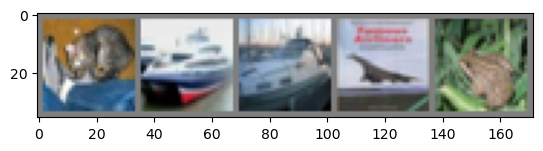

GroundTruth:    cat  ship  ship plane  frog


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images[:5], labels[:5]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % CIFAR_CLASSES[labels[j]] for j in range(5)))

Aplicamos el modelo a las imágenes seleccionadas. Es *muy importante* cambiar el modo del modelo a evaluación.

In [11]:
model.eval();  # Activate evaluation mode

In [12]:
outputs = model(images.view(images.shape[0], -1))  # Remember to flatten the 2D images to a single long tensor with `view`
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % CIFAR_CLASSES[predicted[j]] for j in range(5)))

Predicted:   frog  ship  ship  ship  deer


### Evaluación General

Si queremos medir que tan bien está funcionando en general, necesitamos correr para todos los valores de test:

In [13]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        outputs = model(inputs.view(inputs.shape[0], -1))
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

print(classification_report(y_true, y_pred, target_names=CIFAR_CLASSES))

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       plane       0.45      0.45      0.45      1000
         car       0.38      0.37      0.38      1000
        bird       0.32      0.09      0.14      1000
         cat       0.25      0.08      0.12      1000
        deer       0.33      0.29      0.31      1000
         dog       0.33      0.40      0.36      1000
        frog       0.31      0.49      0.38      1000
       horse       0.29      0.37      0.32      1000
        ship       0.42      0.52      0.47      1000
       truck       0.39      0.48      0.43      1000

    accuracy                           0.36     10000
   macro avg       0.35      0.36      0.34     10000
weighted avg       0.35      0.36      0.34     10000



## Entrenamiento en GPU

El entrenamiento en GPU requiere que "enviemos" el modelo y los datos al GPU. Para ello, se deben cambiar algunas cosas.

### Definir el dispositivo

Primero se define el dispositivo a utilizar. Si se dispone de GPU lo utilizamos, en caso contrario se selecciona el CPU.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Una vez seleccionado el dispositivo, debemos crear y enviar el modelo a dicho dispositivo.

In [15]:
model = MLP()
model.to(device)
model.train();

De aqui los pasos son prácticamente los mismos que para el [entrenamiento](#Entrenamiento). Es importante que definamos nuevamente el algoritmo de optimización sobre los parámetros nuevos que en este caso se enviaron al GPU. Luego, durante el *training loop* debemos asegurarnos de, previo a pasar los datos al modelo, estos sean cargados en el dispositivo:

In [16]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(trainloader), 1):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # run the rest of the algorithm as usual

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

## Listado de referencias

- [Documentación de PyTorch](https://pytorch.org/docs/stable/index.html)
- [PIL Image](https://en.wikipedia.org/wiki/Python_Imaging_Library#:~:text=Python%20Imaging%20Library%20is%20a,version%20of%20PIL%20is%201.1.) = Python Image Library
- [Documentación del módulo torchvision](https://pytorch.org/vision/stable/index.html)
  - [Aquí](https://pytorch.org/vision/stable/transforms.html#compositions-of-transforms) hay información sobre las clases del módulo `torchvision` que se usan en esta notebook.
  -[Clase CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)
  -[Clase Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

[Volver al inicio](#Construyendo-una-red-neuronal-con-PyTorch)